In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45089,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:37337,Total threads: 4
Dashboard: /proxy/35411/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:35717,


### Functions

#### Your original functions:

In [3]:
# Define a function to return a string of 2-digits from a month, day or hour integer.
def mm_dd_hh(n):
    '''This function adds a leading 0 to a single digit month, day or hour number.'''
    
    if n < 10:
        return '0'+str(n)
    else:
        return str(n)

#### Vectorised functions:

Changed the 2 functions just to add a bit of vectorisation instead of loops. They produce the exact same result as before.

In [4]:
def nearest_vect(points, vector):
    '''This function finds the nearest elements in an array of latitude or longitude
    values to the given array of points using numpy's vectorized operations.'''
    
    abs_diff = np.abs(vector[:, None] - points)
    nearest_indices = np.argmin(abs_diff, axis=0)
    return vector[nearest_indices]

Explanation for nearest_vect():

```python
abs_diff = np.abs(vector[:, None] - points)
```
This computes the absolute differences between each value in the provided vector and all values in points using vectorization. ```vector[:, None]``` reshapes the vector array to a 2D array where each element is in a different row. The subtraction then broadcasts points across all rows of vector. The ```np.abs``` function takes an absolute value of the differences to get positive values.

```python
nearest_indices = np.argmin(abs_diff, axis=0)
```
After obtaining the matrix of absolute differences ```(abs_diff)```, the ```np.argmin()``` function finds the indices of the minimum values along the specified axis ```(0 - row-wise)```. These indices correspond to the elements in vector that are closest to each value in points.


```python
return vector[nearest_indices]
```
The function then utilizes these indices to return the elements in the vector array that are closest to each value in points.

In [5]:
# I didn't modify this code much, just put the IF statement into 1 line

def ints_to_str(numerical_values):
    '''This function transforms an array of integers into an array of 
    strings, adding leading zeros where necessary if the number 
    is less than 10.'''
    
    return ['0' + str(int(x)) if int(x) < 10 else str(int(x)) for x in numerical_values]

In [6]:
def cyclone_dataset_IO(list_data_path, filename):

    '''This function combines all the code for wrangling the text file of cyclone instances into a single unit, so it 
    can be reused multiple times. It outputs numpy arrays for the upper and lower latitude and longitude bounds for each 
    cyclone field, a list of the dates, and the total number of cyclone instances. '''

    lows_pd = pd.read_csv(list_data_path + filename, delimiter = ',', header = None)
    lows_pd.columns = ['track', 'year', 'month', 'day', 'hour', 'tstep', 'lat', 'lon', 'z500', 'test1', 'test2']
    
    # Get the year, month, day and hour columns as lists
    yearstring_list = ints_to_str(list(lows_pd['year']))
    monthstring_list = ints_to_str(list(lows_pd['month']))
    daystring_list = ints_to_str(list(lows_pd['day']))
    hourstring_list = ints_to_str(list(lows_pd['hour']))
    
    # Combine the lists into a list of date strings
    date_list = []
    num_dates = len(yearstring_list)
    
    for ii in range(num_dates):
        datestr = yearstring_list[ii] + '-' + monthstring_list[ii] + '-' + daystring_list[ii] + '-' + hourstring_list[ii]
        date_list.append(datestr)
    
    # get arrays of the lat and lon values, to use for finding the nearest grid point to the cyclone centers
    eraint_lats = np.arange(-90, 0, 1)
    eraint_lons = np.arange(-180, 180, 1)
    
    # Create series of the lat and lon values
    lat_lower = np.zeros(num_dates)
    lon_lower = np.zeros(num_dates)
    
    # This part handles the cases where the identified cyclone centers do not match up exactly with the reanalysis grid
    lat_lower = nearest_vect(lows_pd['lat'].values - 15, eraint_lats)
    lon_lower = nearest_vect(lows_pd['lon'].values - 15, eraint_lons)
    
    lat_upper = lat_lower + 30
    lon_upper = lon_lower + 30

    return lat_lower, lat_upper, lon_lower, lon_upper, date_list, num_dates

### Cyclone data

In [7]:
# Open the files of dates and compute corresponding lists of time axis values
list_data_path = '/home/561/nxg561/00_Tracking_Scheme_Comparison/Output_Data/PGvsPV/'

match_filename = 'pg_matches.txt'
pg_filename = 'pg_only.txt'

# call the dataset 1/0 function for each of the three cyclone list files here
match_data = cyclone_dataset_IO(list_data_path, match_filename)
pg_data = cyclone_dataset_IO(list_data_path, pg_filename)

### ERA5 data

In [8]:
# Open the ERA5 geopotential height files as a multi-file dataset
era5_data_path = '/g/data/w40/nxg561/ERA-Int/z*.nc'

In [9]:
# We use this function to get xarray to pre-select info as each data file is opened. 
# It helps to reduce the work needed later.

def preprocessing_500(ds):
    # Pre-select the dimensions
    ds = ds.sel(lat = slice(10, -90), lon = slice(60, 180), lev=50000)
    # Select we want the z variable and divide it now.
    ds = ds.z / 9.8
    
    return ds

def preprocessing_1000(ds):
    # Pre-select the dimensions
    ds = ds.sel(lat = slice(10, -90), lon = slice(60, 180), lev=100000)
    # Select we want the z variable and divide it now.
    ds = ds.z / 9.8
    
    return ds

In [10]:
%%time
z500 = xr.open_mfdataset(era5_data_path, parallel=True, preprocess=preprocessing_500, combine = 'nested', concat_dim = 'time', chunks={'time': 124, 'lat': -1, 'lon': -1})
z1000 = xr.open_mfdataset(era5_data_path, parallel=True, preprocess=preprocessing_1000, combine = 'nested', concat_dim = 'time', chunks={'time': 124, 'lat': -1, 'lon': -1})

CPU times: user 8.49 s, sys: 1.08 s, total: 9.57 s
Wall time: 33.9 s


```parallel=True``` - This argument enables parallel I/O with Dask.

```preprocess=preprocessing``` - This applies the preprocessing function to each file upon opening.

```chunks={'time': 124, 'lat': -1, 'lon': -1}``` - This breaks the dataset down into smaller, manageable chunks along the specified dimensions.

In [36]:
# I don't think this is necessary here, the dataset is pretty small after preprocessing.
#z = xr_obj.chunk(chunks={'time': '70mb'})

In [11]:
%%time

# Now we load the data into memory since it's only 2.42Gb. 
# Loading now actually makes the loop later quicker.
# If this processed data was much bigger then we wouldn't compute now, we'd deploy Dask delayed on the loop
z500_load = z500.compute()
z1000_load = z1000.compute()

CPU times: user 25.8 s, sys: 9.22 s, total: 35 s
Wall time: 3min 5s


In [12]:
# create empty np.array of zeros to insert the system centered fields into. Repeat 3 times for each
# of the three cyclone datasets. 
system_fields_500_match = np.zeros((match_data[5], 31, 31))
system_fields_1000_match = np.zeros((match_data[5], 31, 31))

system_fields_500_pg = np.zeros((pg_data[5], 31, 31))
system_fields_1000_pg = np.zeros((pg_data[5], 31, 31))

In [13]:
%%time

# Loop through each date, extract the geopotential height data field for the cyclone center at that date, and write
# the field into the system fields array. The loop for each cyclone dataset needs to be set up separately. 
for ii in range(match_data[5]):
    
    system_field_500_match = z500_load.sel(lat=slice(match_data[1][ii], match_data[0][ii]), lon=slice(match_data[2][ii], match_data[3][ii]), time=match_data[4][ii]).data
    
    system_fields_500_match[ii,:,:] = system_field_500_match

    system_field_1000_match = z1000_load.sel(lat=slice(match_data[1][ii], match_data[0][ii]), lon=slice(match_data[2][ii], match_data[3][ii]), time=match_data[4][ii]).data
    
    system_fields_1000_match[ii,:,:] = system_field_1000_match

for ii in range(pg_data[5]):
    
    system_field_500_pg = z500_load.sel(lat=slice(pg_data[1][ii], pg_data[0][ii]), lon=slice(pg_data[2][ii], pg_data[3][ii]), time=pg_data[4][ii]).data
    
    system_fields_500_pg[ii,:,:] = system_field_500_pg

    system_field_1000_pg = z1000_load.sel(lat=slice(pg_data[1][ii], pg_data[0][ii]), lon=slice(pg_data[2][ii], pg_data[3][ii]), time=pg_data[4][ii]).data
    
    system_fields_1000_pg[ii,:,:] = system_field_1000_pg

CPU times: user 1min 9s, sys: 5.13 s, total: 1min 14s
Wall time: 1min 11s


In [14]:
%%time

# Compute the mean system-centered field for the matching cyclones
mean_system_field_500_match = np.mean(system_fields_500_match, axis = 0)
mean_system_field_1000_match = np.mean(system_fields_1000_match, axis = 0)

# Compute the mean system-centered field for the pg only cyclones
mean_system_field_500_pg = np.mean(system_fields_500_pg, axis = 0)
mean_system_field_1000_pg = np.mean(system_fields_1000_pg, axis = 0)

CPU times: user 379 ms, sys: 76.3 ms, total: 455 ms
Wall time: 400 ms


### plotting & saving


Text(0, 0.5, 'Center-Relative Latitude')

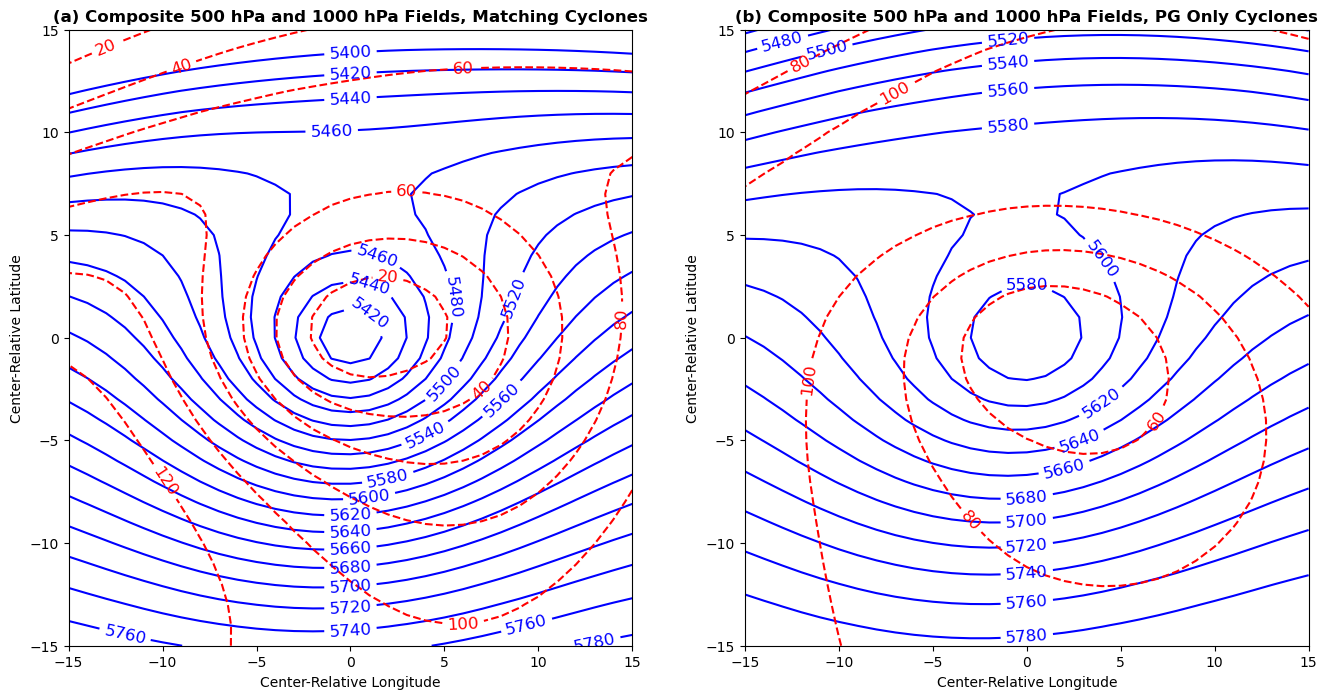

In [16]:
# This part sets up an array of contour levels to plot with a given contour interval
interval = 20
levels_1000 = np.arange(0,200,interval)
levels_500 = np.arange(5400,5800,interval)

# Contour plot the mean system-centered field, with 3 subplots for the 3 cyclone datasets
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Create the grid to orient the contour plot
lat_vector = np.arange(-15,15+1,1)
lon_vector = np.arange(-15,15+1,1)

latall = np.meshgrid(lon_vector, lat_vector)[1]
lonall = np.meshgrid(lon_vector, lat_vector)[0]

# =========== Matching cyclones plot ===========
# Call the contour plot method
#graphic = ax.contour(lonall, latall, mean_system_field_500, 20, colors = 'k')
graphic1 = ax1.contour(lonall, latall, mean_system_field_500_match, colors = 'b', levels = levels_500)
graphic2 = ax1.contour(lonall, latall, mean_system_field_1000_match, colors = 'r', linestyles = 'dashed', levels = levels_1000)

# Add contour labels   
ax1.clabel(graphic1, fontsize=12)
ax1.clabel(graphic2, fontsize=12)

ax1.set_title('(a) Composite 500 hPa and 1000 hPa Fields, Matching Cyclones', weight = 'bold')
ax1.set_xlabel('Center-Relative Longitude')
ax1.set_ylabel('Center-Relative Latitude')

# =========== PG only cyclones plot ===========
# Call the contour plot method
#graphic = ax.contour(lonall, latall, mean_system_field_500, 20, colors = 'k')
graphic3 = ax2.contour(lonall, latall, mean_system_field_500_pg, colors = 'b', levels = levels_500)
graphic4 = ax2.contour(lonall, latall, mean_system_field_1000_pg, colors = 'r', linestyles = 'dashed', levels = levels_1000)

# Add contour labels   
ax2.clabel(graphic3, fontsize=12)
ax2.clabel(graphic4, fontsize=12)

ax2.set_title('(b) Composite 500 hPa and 1000 hPa Fields, PG Only Cyclones', weight = 'bold')
ax2.set_xlabel('Center-Relative Longitude')
ax2.set_ylabel('Center-Relative Latitude')

In [17]:
# Save the graphic
fig.savefig(list_data_path + 'composites_pg_pv.png', format = 'png')

In [18]:
# This only closes the files that have been opened, in our case we called this z
z500.close()
z1000.close()

# To actually remove the data from memory you need to run the following:
del z500_load
del z1000_load